In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import os

In [2]:
def pearson_coeff(x,y):
    std_x = np.std(x)
    std_y = np.std(y)
    cov_xy = np.cov(x,y)[0,1]
    coeff = cov_xy/(std_x*std_y)
    return coeff

# Organization of the data 

In [65]:
list_path = '../output_lists/'
flat_label = 'flat_ids_{0}_{1}.txt'

In [66]:
indir_flats = '../output_fits/{0}_run/'

In [67]:
outdir_plots = '../output_plots/'
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [68]:
filters = ['FELH0600','BG40','SDSSg']

In [69]:
date_dict = {'SDSSg':'20220608','SDSSr':'','empty':'','BG40':'20220608','FELH0600':'20220608'}

In [70]:
'''
flat_ids_dict = {}
for filter in filters:
    flat_ids_file = open(os.path.join(list_path,flat_label.format(date_dict[filter],filter))).readlines()
    flat_ids_ = []
    for line in flat_ids_file:
        flat_ids_.append(line.split('\n')[0])
    flat_ids_ = np.array(flat_ids_)
    flat_ids_dict[filter] = flat_ids_
'''

"\nflat_ids_dict = {}\nfor filter in filters:\n    flat_ids_file = open(os.path.join(list_path,flat_label.format(date_dict[filter],filter))).readlines()\n    flat_ids_ = []\n    for line in flat_ids_file:\n        flat_ids_.append(line.split('\n')[0])\n    flat_ids_ = np.array(flat_ids_)\n    flat_ids_dict[filter] = flat_ids_\n"

In [71]:
outdir_dict = {}
for filter in filters:
    outdir_dict[filter] = '../output_fits/{0}_run/'.format(date_dict[filter])
print(outdir_dict)

filter_files = {}
for filter in filters:
    filter_files[filter] = [f for f in os.listdir(indir_flats.format(date_dict[filter])) if 'master_flat_median_{0}_{1}'.format(date_dict[filter],filter) in f and '_renormalised.fits' in f and 'ratio' not in f][0]
print(filter_files)

{'FELH0600': '../output_fits/20220608_run/', 'BG40': '../output_fits/20220608_run/', 'SDSSg': '../output_fits/20220608_run/'}
{'FELH0600': 'master_flat_median_20220608_FELH0600_87_167_renormalised.fits', 'BG40': 'master_flat_median_20220608_BG40_66_86_renormalised.fits', 'SDSSg': 'master_flat_median_20220608_SDSSg_45_65_renormalised.fits'}


# Setting CCD parameters 

In [10]:
num_segments = 16

In [11]:
seg = 1

In [12]:
hprescan = 3
hoverscan = 64
voverscan = 48

# Testing part (with a couple of filters) to determine the best parameter for median smoothing 

In [13]:
filter1 = 'FELH0600'
filter2 = 'BG40'

In [14]:
fred = fits.open(indir_flats.format(date_dict[filter1])+filter_files[filter1])
fblue = fits.open(indir_flats.format(date_dict[filter2])+filter_files[filter2])

In [15]:
shape0 = fred[1].data.shape

In [16]:
for i in range(1,len(fred)):
    print(i, fred[i].header['EXTNAME'])

1 Segment00
2 Segment01
3 Segment02
4 Segment03
5 Segment04
6 Segment05
7 Segment06
8 Segment07
9 Segment17
10 Segment16
11 Segment15
12 Segment14
13 Segment13
14 Segment12
15 Segment11
16 Segment10


In [17]:
data0red = fred[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
data0blue = fblue[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
data0ratio = data0red/data0blue

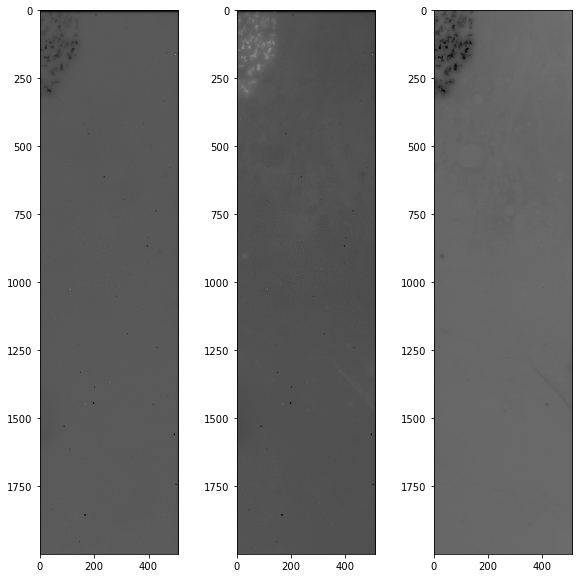

In [18]:
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(131)
ax.imshow(data0red,cmap="gray",vmin=0.85,vmax=1.25)#,norm=LogNorm())
ax=fig.add_subplot(132)
ax.imshow(data0blue,cmap="gray",vmin=0.85,vmax=1.25)#,norm=LogNorm())
ax=fig.add_subplot(133)
ax.imshow(data0ratio,cmap="gray",vmin=0.85,vmax=1.25)#,norm=LogNorm())

In [19]:
fred[seg].header['EXTNAME']

'Segment00'

In [62]:
print(shape0)

(2048, 576)


(2048, 576)


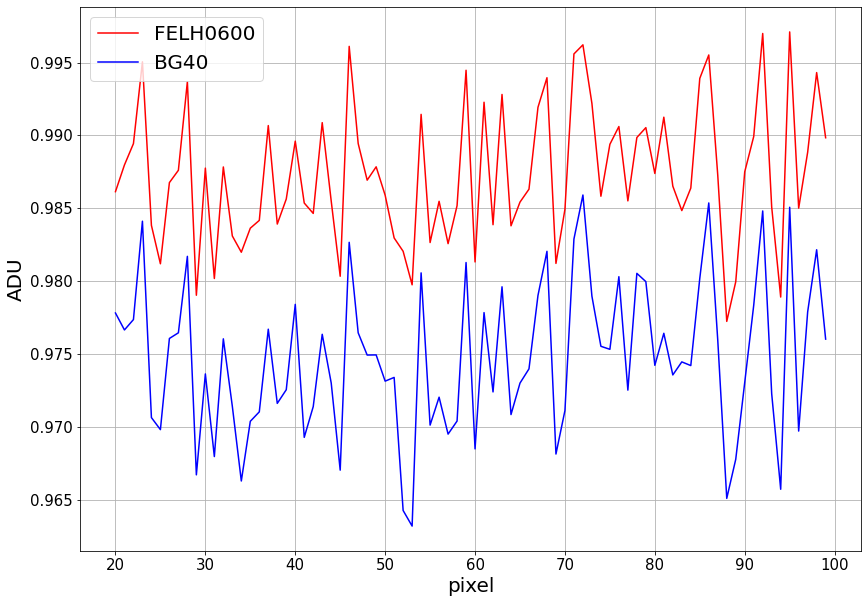

In [20]:
fig = plt.figure(figsize=(14,10))
x_ = np.arange(20,100)
plt.plot(x_,data0red[1500,20:100],color='r',label=filter1)
plt.plot(x_,data0blue[1500,20:100],color='b',label=filter2)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('pixel',fontsize=20)
plt.ylabel('ADU',fontsize=20)
plt.legend(fontsize=20)
plt.savefig(outdir_plots+'comparison_row_{0}_{1}_{2}_{3}_renormalised.png'.format(filter1,filter2,date_dict[filter1],date_dict[filter2]))

In [21]:
print(pearson_coeff(data0red[1500,20:100],data0blue[1500,20:100]))

0.9671128099680839


In [22]:
print(np.mean(data0red),np.median(data0red),np.std(data0red))
print(np.mean(data0blue),np.median(data0blue),np.std(data0blue))
print(np.mean(data0ratio),np.median(data0ratio),np.std(data0ratio))

0.9873457959067055 0.9883918698346137 0.017260128196595167
0.9770957811266332 0.9762406907005866 0.02027121865101406
1.0106294821663946 1.013041084023875 0.01248023512194818


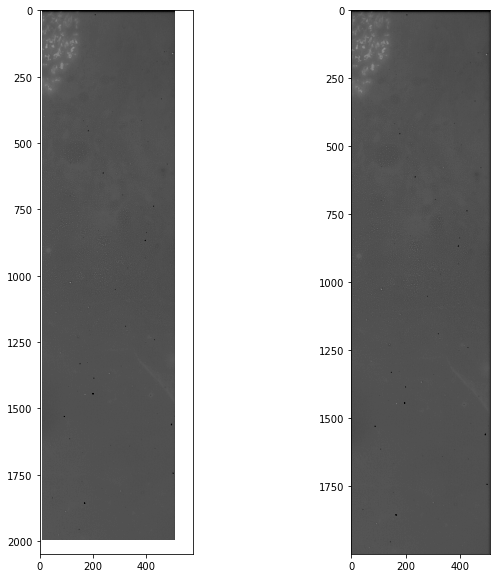

In [23]:
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(121)
ax.imshow(fblue[seg].data,cmap="gray",vmin=0.85,vmax=1.25)#,norm=LogNorm())
ax=fig.add_subplot(122)
ax.imshow(data0blue,cmap="gray",vmin=0.85,vmax=1.25)#,norm=LogNorm())

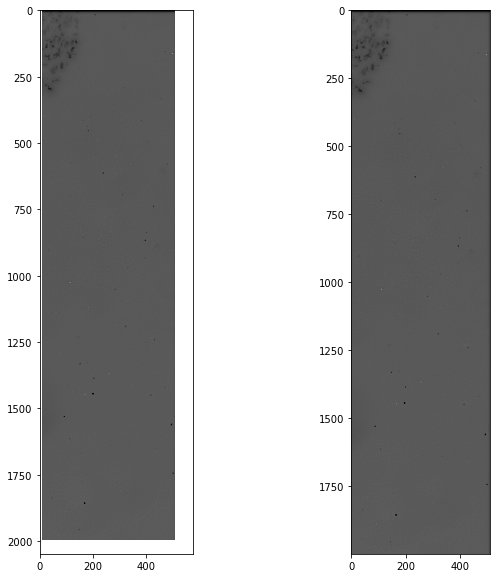

In [24]:
# If not specified, by default, the data is plotted with the origin on top of the image 
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(121)
ax.imshow(fred[seg].data,cmap="gray",vmin=0.85,vmax=1.25)#,norm=LogNorm())
ax=fig.add_subplot(122)
ax.imshow(data0red,cmap="gray",vmin=0.85,vmax=1.25)#,norm=LogNorm())

# Median smoothing 

In [25]:
test = data0red

In [26]:
test_median_ = np.median(data0red.ravel())

In [27]:
smooth0 = ndimage.median_filter(test, size=2)
smooth1 = ndimage.median_filter(test, size=5)
smooth2 = ndimage.median_filter(test, size=10)
smooth3 = ndimage.median_filter(test, size=20)
smooth4 = ndimage.median_filter(test, size=40)

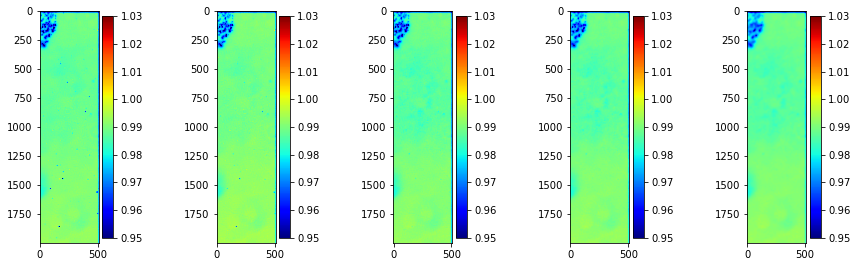

In [29]:
fig = plt.figure(figsize=(14,14))
ax=fig.add_subplot(191)
im=ax.imshow(test,cmap="jet",vmin=0.95,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im, ax=ax)
ax=fig.add_subplot(193)
im=ax.imshow(smooth0,cmap="jet",vmin=0.95,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im, ax=ax)
ax=fig.add_subplot(195)
im=ax.imshow(smooth1,cmap="jet",vmin=0.95,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im, ax=ax)
ax=fig.add_subplot(197)
im=ax.imshow(smooth2,cmap="jet",vmin=0.95,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im, ax=ax)
ax=fig.add_subplot(199)
im=ax.imshow(smooth3,cmap="jet",vmin=0.95,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im, ax=ax)

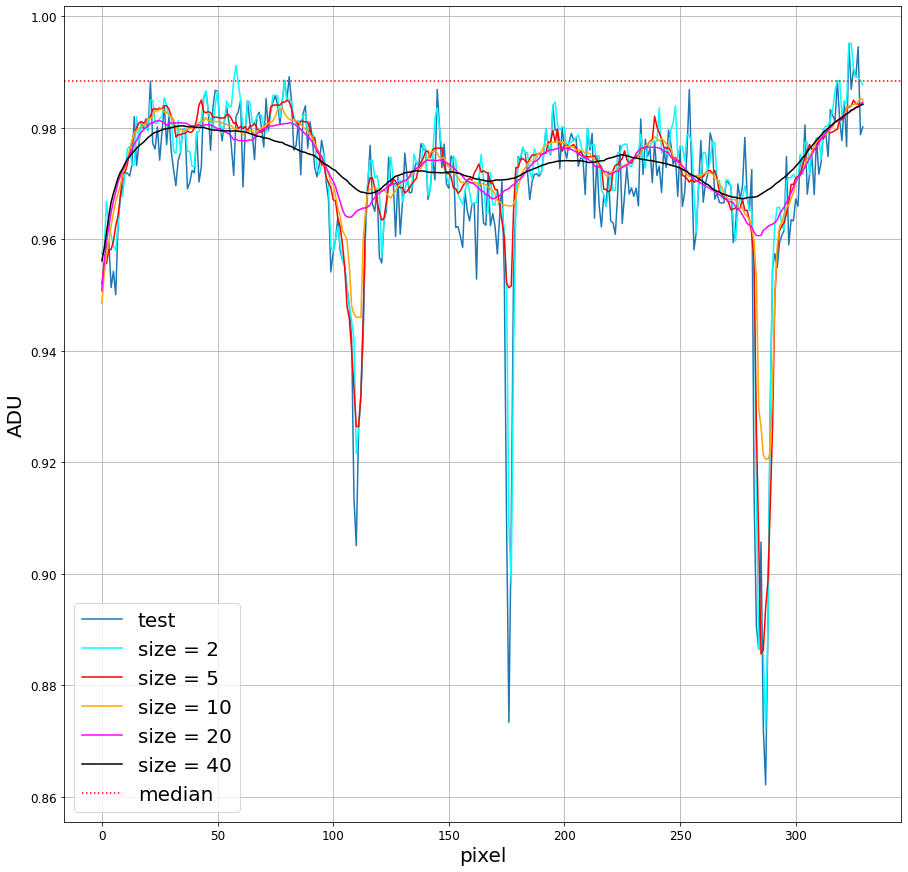

In [30]:
column = 36
y0 = 10
y1 = 340
fig = plt.figure(figsize=(15,15))
plt.plot(test[y0:y1,column],label='test')
plt.plot(smooth0[y0:y1,column],label='size = 2',color='cyan')
plt.plot(smooth1[y0:y1,column],label='size = 5',color='r')
plt.plot(smooth2[y0:y1,column],label='size = 10',color='orange')
plt.plot(smooth3[y0:y1,column],label='size = 20',color='magenta')
plt.plot(smooth4[y0:y1,column],label='size = 40',color='k')
plt.axhline(y=test_median_,ls=':',color='r',label='median')
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('pixel',fontsize=20)
plt.ylabel('ADU',fontsize=20)
plt.legend(fontsize=20)
plt.savefig(outdir_plots+'column{0}_{1}register_master_flat_{2}_renormalised_{3}.png'.format(column,seg,filter1,date_dict[filter1]))

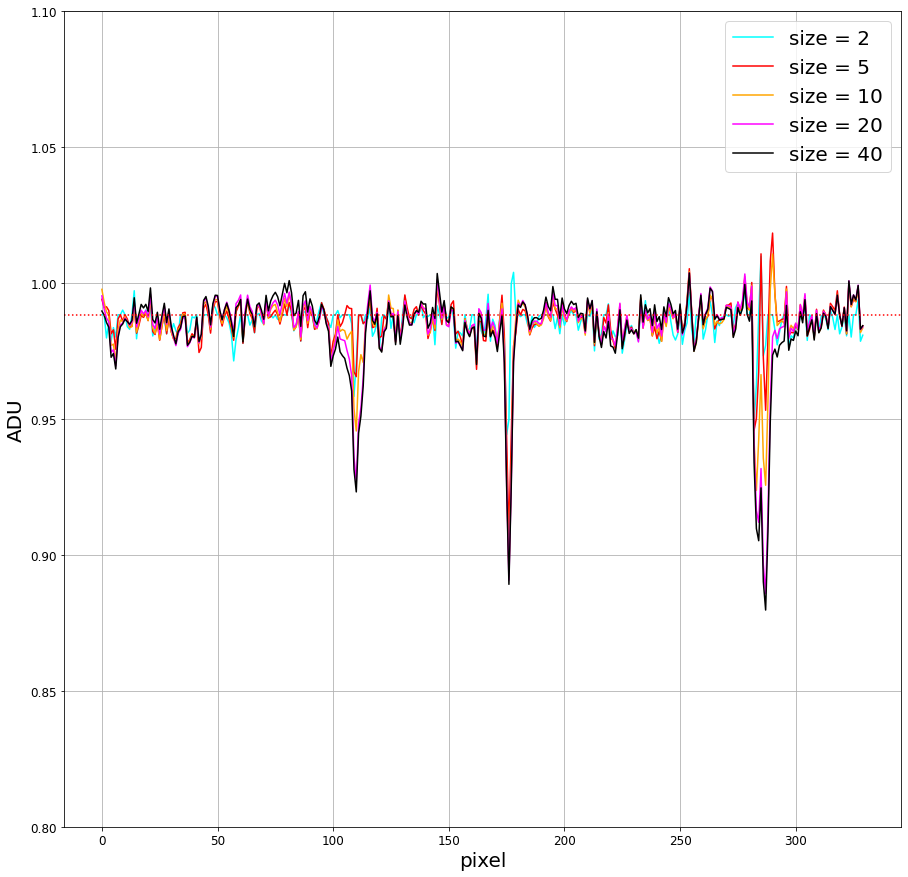

In [31]:
fig = plt.figure(figsize=(15,15))
plt.plot(test[y0:y1,column]*test_median_/smooth0[y0:y1,column],label='size = 2',color='cyan')
plt.plot(test[y0:y1,column]*test_median_/smooth1[y0:y1,column],label='size = 5',color='r')
plt.plot(test[y0:y1,column]*test_median_/smooth2[y0:y1,column],label='size = 10',color='orange')
plt.plot(test[y0:y1,column]*test_median_/smooth3[y0:y1,column],label='size = 20',color='magenta')
plt.plot(test[y0:y1,column]*test_median_/smooth4[y0:y1,column],label='size = 40',color='k')
plt.axhline(y=test_median_,ls=':',color='r')
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('pixel',fontsize=20)
plt.ylabel('ADU',fontsize=20)
plt.ylim(0.8,1.1)
plt.legend(fontsize=20)
plt.savefig(outdir_plots+'column{0}_{1}register_master_flat_{2}_{3}_smoothed_renormalised.png'.format(column,seg,filter1,date_dict[filter1]))

In [32]:
#print(np.mean(test[:,column]/smooth0[:,column]).round(4),np.std(test[:,column]/smooth0[:,column]).round(4))
print(np.mean(test[:,column]*test_median_/smooth0[:,column]).round(4),np.std(test[:,column]*test_median_/smooth0[:,column]).round(4))
print(np.mean(test[:,column]*test_median_/smooth1[:,column]).round(4),np.std(test[:,column]*test_median_/smooth1[:,column]).round(4))
print(np.mean(test[:,column]*test_median_/smooth2[:,column]).round(4),np.std(test[:,column]*test_median_/smooth2[:,column]).round(4))
print(np.mean(test[:,column]*test_median_/smooth3[:,column]).round(4),np.std(test[:,column]*test_median_/smooth3[:,column]).round(4))
print(np.mean(test[:,column]*test_median_/smooth4[:,column]).round(4),np.std(test[:,column]*test_median_/smooth4[:,column]).round(4))
#print(np.mean(test[:,column]/smooth5[:,column]).round(4),np.std(test[:,column]/smooth5[:,column]).round(4))

0.9862 0.0061
0.9867 0.0096
0.9864 0.0113
0.9861 0.0145
0.9857 0.0166


# Iterate over some size values for the smoothing and compare STD 

In [33]:
test.shape

(2000, 509)

In [34]:
#sigmas = [2,5,10,20,40,80,160,320,640,1280,2560]
sizes = [2,5,10,20,40,80]#,160,320,355,509,640]

In [35]:
std_raw = np.std(test)
print(std_raw)

0.017260128196595167


In [36]:
smooth_dict = {}
smooth_std = []
for size in sizes:
    smooth_ = ndimage.median_filter(test, size=size)
    #data_smooth = test/smooth_
    data_smooth = test*test_median_/smooth_
    smooth_dict[size] = smooth_
    smooth_std.append(np.std(data_smooth))
smooth_std = np.array(smooth_std)

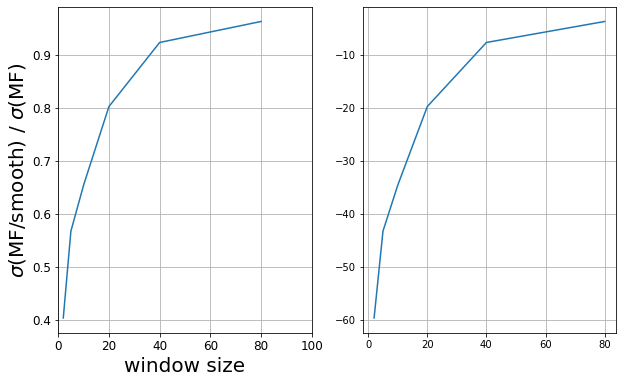

In [37]:
x = np.array(sizes)
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
ax.plot(x,smooth_std/std_raw)
plt.grid()
plt.xlim(0.,100.)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('window size',fontsize=20)
plt.ylabel(r'$\sigma$'+'(MF/smooth) / '+r'$\sigma$'+'(MF)',fontsize=20)
plt.savefig(outdir_plots+'standard_deviation_vs_median_size_{0}_{1}_renormalised.png'.format(filter1,date_dict[filter1]))
ax=fig.add_subplot(122)
ax.plot(x,(smooth_std-std_raw)*100./std_raw)
plt.grid()

In [38]:
smooth_dict.keys()

dict_keys([2, 5, 10, 20, 40, 80])

In [61]:
size_median_ = 40

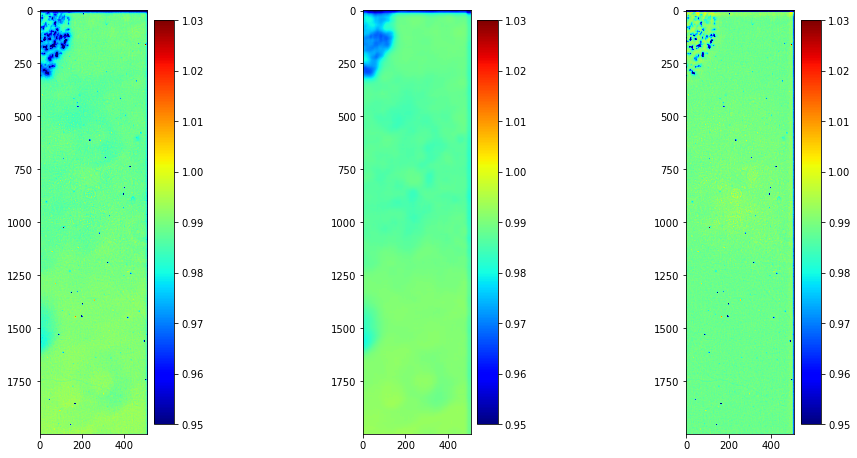

In [39]:
fig = plt.figure(figsize=(14,14))
ax=fig.add_subplot(151)
im1 = ax.imshow(test,cmap="jet",vmin=0.95,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im1, ax=ax)
ax=fig.add_subplot(153)
im2=ax.imshow(smooth_dict[size_median_],cmap="jet",vmin=0.95,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im2, ax=ax)
ax=fig.add_subplot(155)
im3=ax.imshow(test*test_median_/smooth_dict[size_median_],cmap="jet",vmin=0.95,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im3, ax=ax)
plt.savefig(outdir_plots+'master_flat_smoothted_{0}_{1}_{2}register_renormalised.png'.format(filter1,date_dict[filter1],seg))

In [40]:
print(np.median(test.ravel()))
print(np.median(smooth_dict[size_median_].ravel()))
#print(np.median(test.ravel()/smooth_dict[size_median_].ravel()))
print(np.median(test.ravel()*test_median_/smooth_dict[size_median_].ravel()))

0.9883918698346137
0.9881305202788099
0.9883902776190381


# Fix size and repeat for the blue filter 

In [41]:
size_median = 40

In [42]:
testr = test
smoothr = smooth_dict[size_median]
testr_median = np.median(testr.ravel())

In [43]:
testb = data0blue

In [45]:
smoothb = ndimage.median_filter(testb, size=size_median)

In [46]:
testb_median = np.median(data0blue.ravel())

In [47]:
ratio_smooth = (testr.ravel()*testr_median/smoothr.ravel())/(testb.ravel()*testb_median/smoothb.ravel())

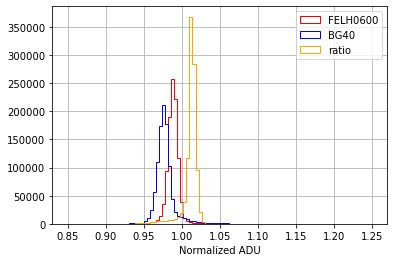

In [48]:
#fig = plt.figure(figsize=(8,8))
plt.hist(testr.ravel(),bins=100,range=(0.85,1.25),histtype='step',color='r',label=filter1)
plt.hist(testb.ravel(),bins=100,range=(0.85,1.25),histtype='step',color='b',label=filter2)
plt.hist(data0ratio.ravel(),bins=100,range=(0.85,1.25),histtype='step',color='orange',label='ratio')
plt.xlabel('Normalized ADU')
plt.grid()
plt.legend()
plt.savefig(outdir_plots+'histogram_master_flats_renormalised_{0}_{1}_{2}_{3}.png'.format(filter1,date_dict[filter1],filter2,date_dict[filter2]))

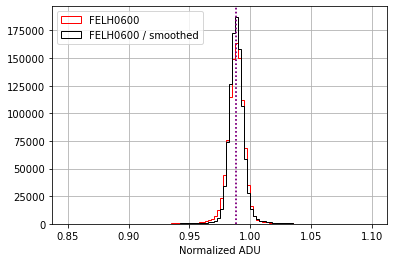

In [49]:
plt.hist(testr.ravel(),bins=100,range=(0.85,1.10),histtype='step',color='r',label=filter1)
plt.hist(testr.ravel()*testr_median/smoothr.ravel(),bins=100,range=(0.85,1.10),histtype='step',color='k',label=filter1+' / smoothed')
plt.axvline(x=np.median(testr.ravel()),ls=':',color='purple')
plt.axvline(x=np.median(testr.ravel()*testr_median/smoothr.ravel()),ls=':',color='purple')
plt.xlabel('Normalized ADU')
plt.grid()
plt.legend(loc="upper left")
plt.savefig(outdir_plots+'histogram_{0}_{1}_with_without_smoothing_renormalised.png'.format(filter1,date_dict[filter1]))

In [50]:
print(np.median(testr.ravel()))
print(np.median(testr.ravel()*testr_median/smoothr.ravel()))

0.9883918698346137
0.9883902776190381


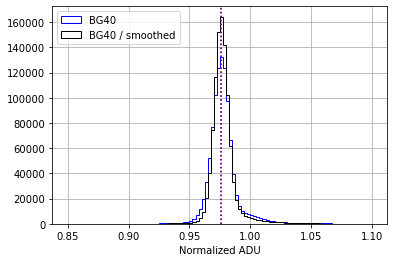

In [51]:
plt.hist(testb.ravel(),bins=100,range=(0.85,1.10),histtype='step',color='b',label=filter2)
plt.hist(testb.ravel()*testb_median/smoothb.ravel(),bins=100,range=(0.85,1.10),histtype='step',color='k',label=filter2+' / smoothed')
plt.axvline(x=np.median(testb.ravel()),ls=':',color='purple')
plt.axvline(x=np.median(testb.ravel()*testb_median/smoothb.ravel()),ls=':',color='purple')
plt.xlabel('Normalized ADU')
plt.grid()
plt.legend(loc="upper left")
plt.savefig(outdir_plots+'histogram_{0}_{1}_with_without_smoothing_renormalised.png'.format(filter2,date_dict[filter2]))

In [52]:
print(np.median(testb.ravel()))
print(np.median(testb.ravel()*testb_median/smoothb.ravel()))

0.9762406907005866
0.9762143382363986


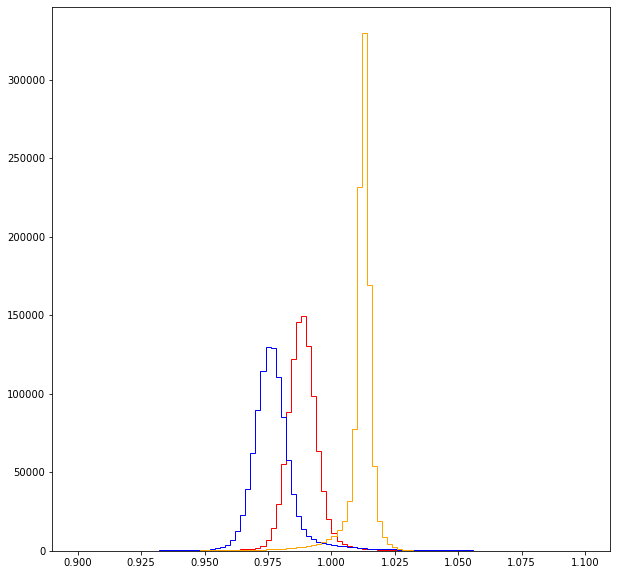

In [53]:
fig = plt.figure(figsize=(10,10))
nr,binsr,_=plt.hist(testr.ravel()*testr_median/smoothr.ravel(),bins=100,color='r',histtype='step',range=(0.9,1.1))
nb,binsb,_=plt.hist(testb.ravel()*testb_median/smoothb.ravel(),bins=100,color='b',histtype='step',range=(0.9,1.1))
nratio,binsratio,_=plt.hist(ratio_smooth,bins=100,color='orange',histtype='step',range=(0.9,1.1))

In [54]:
print(np.sum(nr),np.sum(nb))

1015146.0 1014293.0


In [55]:
print(len(test.ravel()))

1018000


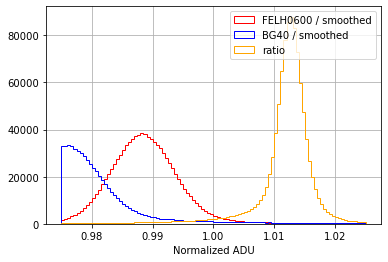

In [56]:
#USE this one 
nr,binsr,_=plt.hist(testr.ravel()*testr_median/smoothr.ravel(),bins=100,color='r',histtype='step',range=(0.975,1.025),label=filter1+' / smoothed')
nb,binsb,_=plt.hist(testb.ravel()*testb_median/smoothb.ravel(),bins=100,color='b',histtype='step',range=(0.975,1.025),label=filter2+' / smoothed')
nratio,binsratio,_=plt.hist(ratio_smooth,bins=100,color='orange',histtype='step',range=(0.975,1.025),label='ratio')
plt.xlabel('Normalized ADU')
plt.grid()
plt.legend()
plt.savefig(outdir_plots+'histogram_master_flats_smoothing_renormalised_{0}_{1}_{2}_{3}.png'.format(filter1,date_dict[filter1],filter2,date_dict[filter2]))

# Create fits files for median smoothed flats 

In [60]:
save_filters = ['FELH0600','BG40','SDSSg']

In [82]:
for filter in save_filters:
    print('#######################################'+filter)
    f = fits.open(filter_files[filter])
    
    #flat_ids = flat_ids_dict[filter]
    
    new_hdul = fits.HDUList()
    hdu1 = fits.PrimaryHDU()
    hdu1.header = f[0].header
    hdu1.header['PROCESS'] = 'Smooth-Master-Flat'
    hdu1.data = f[0].data
    new_hdul.append(hdu1)
    for seg in range(1,num_segments+1):
        print(seg)
        hdu2 = fits.ImageHDU()
        data_seg = f[seg].data 
        data_seg_smooth = np.zeros(data_seg.shape)
        data_seg_smooth[shape0[0]-voverscan:,:] = data_seg[shape0[0]-voverscan:,:]
        data_seg_smooth[:,:hprescan] = data_seg[:,:hprescan]
        data_seg_smooth[:,shape0[1]-hoverscan:] = data_seg[:,shape0[1]-hoverscan:]
        data_seg_ = data_seg[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
        seg_median_ = np.median(data_seg_.ravel())
        smooth = ndimage.median_filter(data_seg_, size=size_median)
        data_seg_smooth[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan] = data_seg_*seg_median_/smooth
        
        hdu2.header = f[seg].header
        hdu2.data = data_seg_smooth
        #median_flats[filter] = median_flat
        new_hdul.append(hdu2)
        print('----------')
    f.close()
    print(len(new_hdul))
    #new_hdul.writeto(outdir_dict[filter]+'master_flat_median_{0}_{1}_{2}_{3}_renormalised_high_frequency.fits'.format(date_dict[filter].replace("-",""),filter,int(np.min(flat_ids.astype('float'))),int(np.max(flat_ids.astype('float')))), overwrite=True)
    new_hdul.writeto(outdir_dict[filter]+files_dict[filter][:-5]+'_high_frequency.fits', overwrite=True)

#######################################BG40
1
----------
2
----------
3
----------
4
----------
5
----------
6
----------
7
----------
8
----------
9
----------
10
----------
11
----------
12
----------
13
----------
14
----------
15
----------
16
----------
17
#######################################SDSSg
1
----------
2
----------
3
----------
4
----------
5
----------
6
----------
7
----------
8
----------
9
----------
10
----------
11
----------
12
----------
13
----------
14
----------
15
----------
16
----------
17
